## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

In [51]:
# Imports 

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

### First, I'll compute the camera calibration using chessboard images

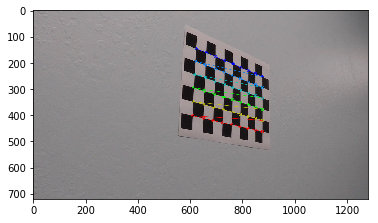

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img);

#Get calibration points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)

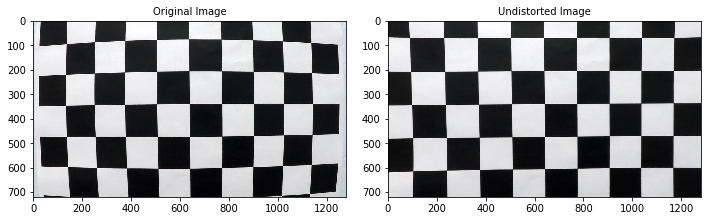

In [3]:
def undistort(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = undistort(img, objpoints, imgpoints)

f, ax = plt.subplots(1, 2, figsize=(10, 9))
f.tight_layout()
ax[0].imshow(img);
ax[0].set_title('Original Image', fontsize=10);

ax[1].imshow(undistorted);
ax[1].set_title('Undistorted Image', fontsize=10);

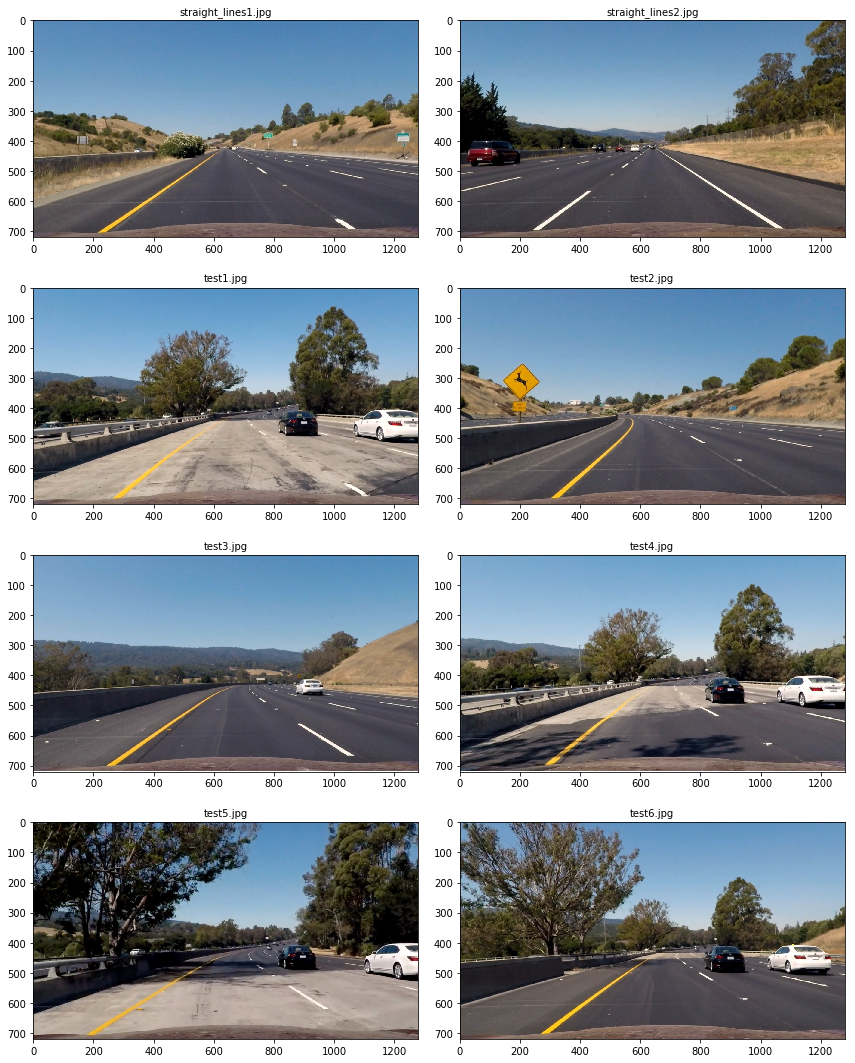

In [4]:
# Test Images
test_images = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(4, 2, figsize=(12, 15));
f.tight_layout()

images = []
undistorted_images = []
ax1, ax2 = 0, 0
for fname in test_images:
    img = cv2.cvtColor( cv2.imread(fname), cv2.COLOR_BGR2RGB)
    
    images.append(img)
    
    undist = undistort(img, objpoints, imgpoints)
    undistorted_images.append( undist )
    
    ax[ax1, ax2].imshow( undist )
    ax[ax1, ax2].set_title(fname.split('/')[1], fontsize=10)
        
    if ax2==1:
        ax2=0
        ax1+=1
    else:
        ax2+=1

### Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
# Thresholding Functions

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255) ):
    # Apply the following steps to img
    # 1) Receive 1chanel img    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    binary_output = sxbinary#np.copy(img) # Remove this line
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(sobelX**2 + sobelY**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobelMag/np.max(sobelMag))
    
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    
    return binary_output


def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelX = np.absolute(sobelX)
    abs_sobelY = np.absolute(sobelY)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobelY, abs_sobelX)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(dir)
    sxbinary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

def gradient_threshold(img, ksize=3):
    """Applies sobel thresholds and returns a combined image"""
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ch1 = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    ch1 = ch1[:,:,2]
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(ch1, orient='x', sobel_kernel=ksize, thresh=(30, 150))
    grady = abs_sobel_thresh(ch1, orient='y', sobel_kernel=ksize, thresh=(35, 150))
    mag_binary = mag_thresh(ch1, sobel_kernel=ksize, mag_thresh=(40, 150))
    dir_binary = dir_thresh(ch1, sobel_kernel=ksize, thresh=(.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined
    
def color_thresh(img, thresh=(0, 255), thresh2=(0, 255)):
    """Filter color from an RGB image"""
    R = img[:,:,0]

    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    HLS_S = HLS[:,:,2]

    binary = np.zeros_like(R)
    binary[((R>=thresh[0])&(R<=thresh[1])) | ((HLS_S>=thresh2[0])&(HLS_S<=thresh2[1])) ] = 1
    return binary

def threshold(img):
    """Combines Gradient and Color thresholds"""
    # Gradient Threshold
    gradient_binary = gradient_threshold(img, ksize=5)
    
    # Color Treshold
    color_binary = color_thresh(img, (220, 255), (150,254))

    #Combine color and gradient threshold
    color_grad_thresh = np.zeros_like(gradient_binary)
    color_grad_thresh[(gradient_binary==1)|(color_binary==1)] = 1 
    
    return color_grad_thresh

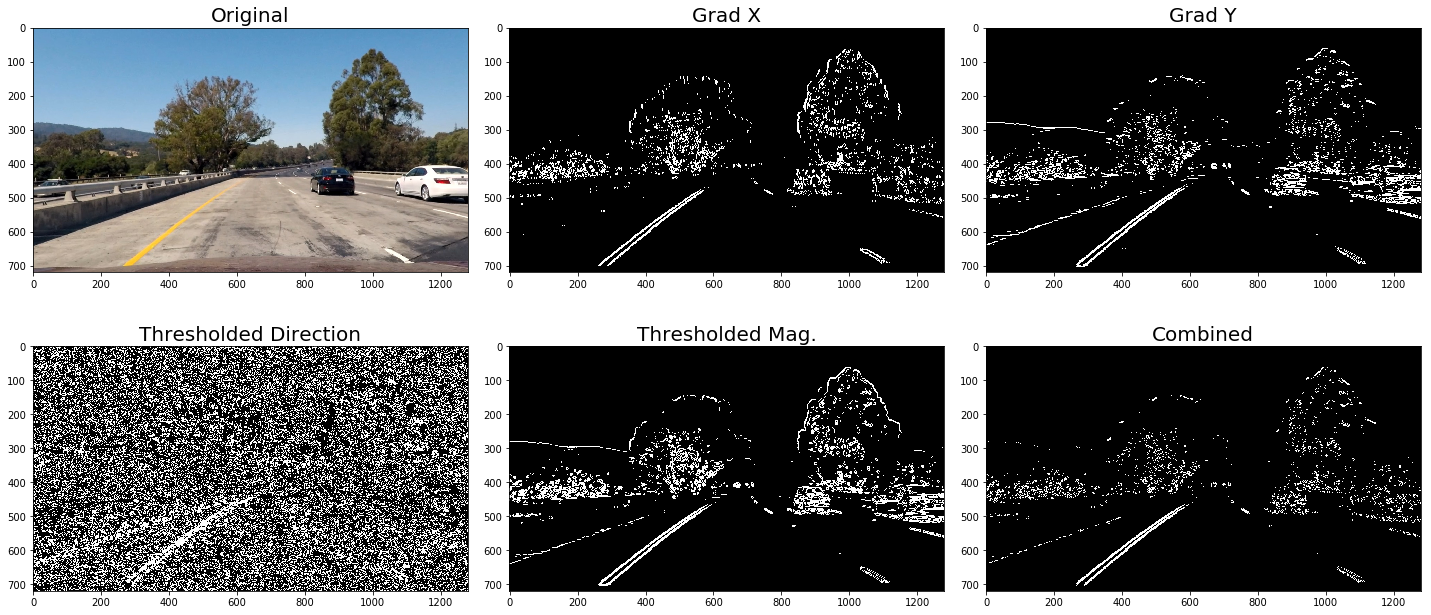

In [6]:
# Gradient treshold test

#image = undistort(cv2.cvtColor( cv2.imread("test_images2/img1.png"), cv2.COLOR_BGR2RGB), objpoints, imgpoints)
image = undistorted_images[2]
#sobel_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
sobel_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
sobel_img = sobel_img[:,:,2]

# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(sobel_img, orient='x', sobel_kernel=ksize, thresh=(30, 150))
grady = abs_sobel_thresh(sobel_img, orient='y', sobel_kernel=ksize, thresh=(35, 150))

mag_binary = mag_thresh(sobel_img, sobel_kernel=ksize, mag_thresh=(40, 150))
dir_binary = dir_thresh(sobel_img, sobel_kernel=ksize, thresh=(.8, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


### Visualization
f, ax = plt.subplots(2, 3, figsize=(20, 9))
f.tight_layout()

ax[0,0].imshow( image );
ax[0,0].set_title('Original', fontsize=20);

ax[0,1].imshow(gradx, cmap='gray');
ax[0,1].set_title('Grad X', fontsize=20);

ax[0,2].imshow(grady, cmap='gray');
ax[0,2].set_title('Grad Y', fontsize=20);

ax[1,0].imshow(dir_binary, cmap='gray');
ax[1,0].set_title('Thresholded Direction', fontsize=20);

ax[1,1].imshow(mag_binary, cmap='gray');
ax[1,1].set_title('Thresholded Mag.', fontsize=20);

ax[1,2].imshow(combined, cmap='gray');
ax[1,2].set_title('Combined', fontsize=20);

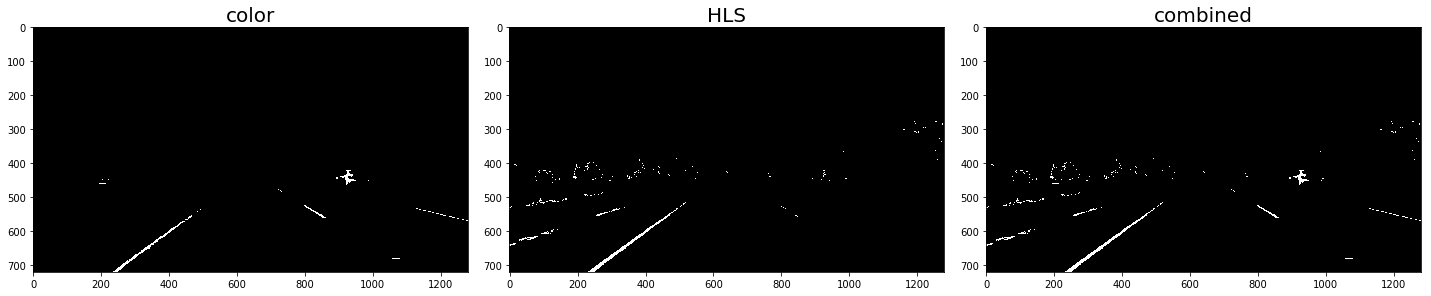

In [7]:
# Color threshold test
image = undistort(cv2.cvtColor( cv2.imread("test_images2/img1.png"), cv2.COLOR_BGR2RGB), objpoints, imgpoints)
#image = undistorted_images[7]

R = image[:,:,0]
color = np.zeros_like(R)
color[(R>=220)&(R<=255)] = 1

HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
HLS_S = HLS[:,:,2]
S_bin = np.zeros_like(HLS_S)
S_bin[(HLS_S>=150)&(HLS_S<=254)] = 1

f, ax = plt.subplots(1, 3, figsize=(20, 9))
f.tight_layout()

ax[0].imshow( color, cmap="gray" );
ax[0].set_title('color', fontsize=20);

ax[1].imshow( S_bin, cmap="gray" );
ax[1].set_title('HLS', fontsize=20);

ax[2].imshow( color_thresh(image, (220, 255), (150,254)), cmap="gray" );
ax[2].set_title('combined', fontsize=20);

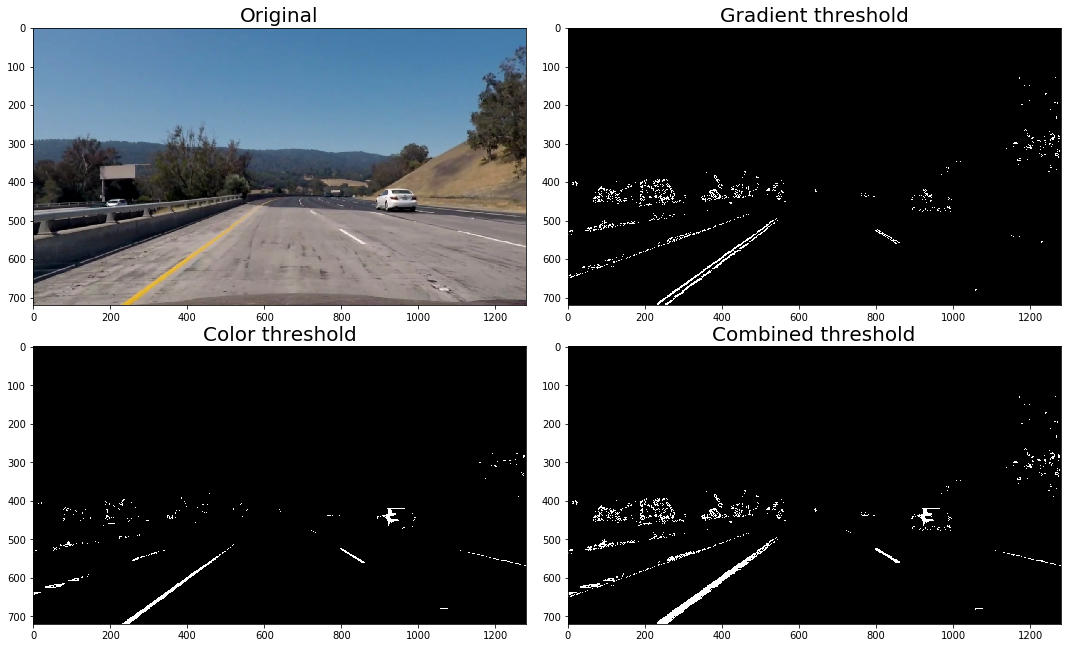

In [8]:
# Threshold final result

image = undistort(cv2.cvtColor( cv2.imread("test_images2/img1.png"), cv2.COLOR_BGR2RGB), objpoints, imgpoints)
#image = undistorted_images[2]

f, ax = plt.subplots(2, 2, figsize=(15, 9))
f.tight_layout()

ax[0,0].imshow( image );
ax[0,0].set_title('Original', fontsize=20);

ax[0,1].imshow(gradient_threshold(image, ksize=5), cmap='gray');
ax[0,1].set_title('Gradient threshold', fontsize=20);

ax[1,0].imshow(color_thresh(image, (220, 255), (150,254)), cmap='gray');
ax[1,0].set_title('Color threshold', fontsize=20);

ax[1,1].imshow(threshold(image), cmap='gray');
ax[1,1].set_title('Combined threshold', fontsize=20);

### Apply a perspective transform to rectify binary image ("birds-eye view").

In [9]:
# Transformation matrix and functions
src = np.float32(
    [[700, 460],
     [1000, 680],
     [300, 680],
     [580, 460]])

dst = np.float32(
    [[980, 0],
     [950, 720],
     [350, 720],
     [320, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
    
def warp(img, inverse=False):
    img_size = (img.shape[1], img.shape[0])
    
    if inverse:
        warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped

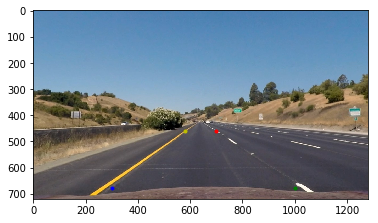

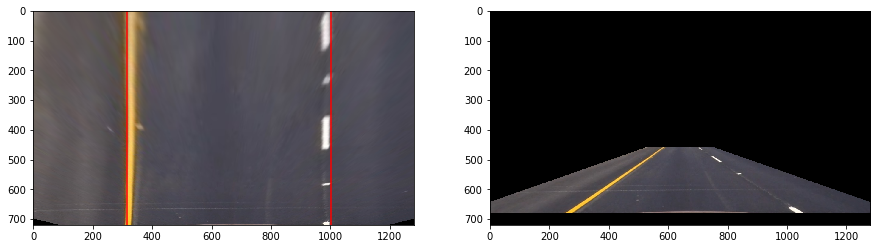

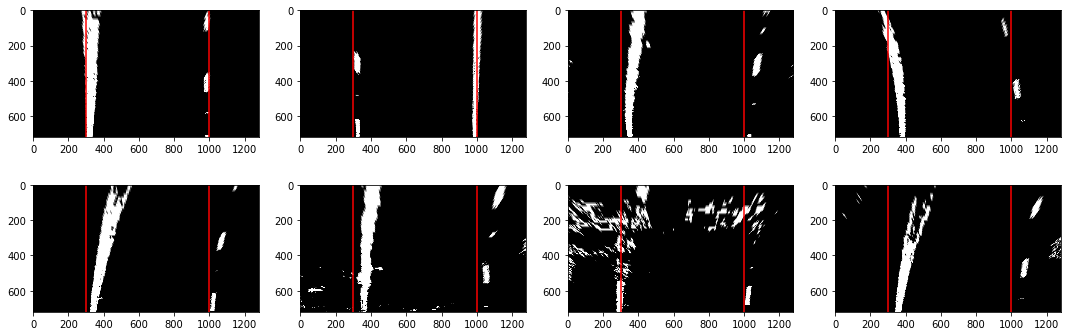

In [10]:
# test warped images
img = undistorted_images[0]

warped = warp(img)
unwarped = warp(warped, True)

plt.imshow( img )
plt.plot(src[0][0],src[0][1], '.r');
plt.plot(src[1][0],src[1][1], '.g');
plt.plot(src[2][0],src[2][1], '.b');
plt.plot(src[3][0],src[3][1], '.y');

f, ax = plt.subplots(1, 2, figsize=(15, 5));
ax[0].imshow( warped );
ax[0].plot([1002, 1002],[0,719], 'r-');
ax[0].plot([317, 317],[0,719], 'r-');

ax[1].imshow( unwarped );

# preview test images
warped_images = []

f, ax = plt.subplots(2, 4, figsize=(15, 5));
f.tight_layout()

row, col = 0, 0
for img in undistorted_images:
    warped = warp(threshold(img))
    warped_images.append(warped)
    ax[row,col].imshow( warped, cmap="gray" );
    ax[row,col].plot([1000, 1000],[0,719], 'r-');
    ax[row,col].plot([300, 300],[0,719], 'r-');
       
    col+=1
    if col==4:
        col=0
        row+=1

### Detect lane pixels and fit to find the lane boundary.

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        
        #polynomial coefficients of the last n fits of the line
        self.recent_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def sliding_windows(binary_warped, lines):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    lines[0].allx = nonzerox[left_lane_inds]
    lines[0].ally = nonzeroy[left_lane_inds] 
    lines[1].allx = nonzerox[right_lane_inds]
    lines[1].ally = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    lines[0].current_fit = np.polyfit(lines[0].ally, lines[0].allx, 2)
    lines[1].current_fit = np.polyfit(lines[1].ally, lines[1].allx, 2)
    
    # Color each side
    out_img[lines[0].ally, lines[0].allx] = [255, 0, 0]
    out_img[lines[1].ally, lines[1].allx] = [0, 0, 255]
    
    # TODO Sanity Check
    lines[0].detected = True
    lines[1].detected = True
    
    #Draw fitted line
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = lines[0].current_fit[0]*ploty**2 + lines[0].current_fit[1]*ploty + lines[0].current_fit[2]
    right_fitx = lines[1].current_fit[0]*ploty**2 + lines[1].current_fit[1]*ploty + lines[1].current_fit[2]

    pts = np.array(list(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(out_img,[pts],False,(255,255,0), 3, lineType=8)

    pts2 = np.array(list(zip(right_fitx, ploty)), np.int32)
    cv2.polylines(out_img,[pts2],False,(255,255,0), 3, lineType=8)
    
    return out_img.astype('uint8')


def line_margin(binary_warped, lines):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    prev_window_img = np.zeros_like(out_img)
    window_img = np.zeros_like(out_img)
    
    # Draw previous line
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = lines[0].current_fit[0]*ploty**2 + lines[0].current_fit[1]*ploty + lines[0].current_fit[2]
    right_fitx = lines[1].current_fit[0]*ploty**2 + lines[1].current_fit[1]*ploty + lines[1].current_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(prev_window_img, np.int_([left_line_pts]), (0,255, 255))
    cv2.fillPoly(prev_window_img, np.int_([right_line_pts]), (0,255, 255))
    
    # Find new points
    left_lane_inds = ((nonzerox > (lines[0].current_fit[0]*(nonzeroy**2) + 
                                   lines[0].current_fit[1]*nonzeroy + 
                                   lines[0].current_fit[2] - margin)) & 
                      (nonzerox < (lines[0].current_fit[0]*(nonzeroy**2) + 
                                   lines[0].current_fit[1]*nonzeroy + 
                                   lines[0].current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (lines[1].current_fit[0]*(nonzeroy**2) + 
                                    lines[1].current_fit[1]*nonzeroy + 
                                    lines[1].current_fit[2] - margin)) & 
                       (nonzerox < (lines[1].current_fit[0]*(nonzeroy**2) + 
                                    lines[1].current_fit[1]*nonzeroy + 
                                    lines[1].current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    lines[0].allx = nonzerox[left_lane_inds]
    lines[0].ally = nonzeroy[left_lane_inds] 
    lines[1].allx = nonzerox[right_lane_inds]
    lines[1].ally = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    lines[0].current_fit = np.polyfit(lines[0].ally, lines[0].allx, 2)
    lines[1].current_fit = np.polyfit(lines[1].ally, lines[1].allx, 2)
    
    # Draw new line
    left_fitx = lines[0].current_fit[0]*ploty**2 + lines[0].current_fit[1]*ploty + lines[0].current_fit[2]
    right_fitx = lines[1].current_fit[0]*ploty**2 + lines[1].current_fit[1]*ploty + lines[1].current_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    search_windows = cv2.addWeighted(window_img, 1, prev_window_img, 0.3, 0)
    
    # Color each side
    out_img[lines[0].ally, lines[0].allx] = [255, 0, 0]
    out_img[lines[1].ally, lines[1].allx] = [0, 0, 255]    

    result = cv2.addWeighted(out_img, 1, search_windows, 0.3, 0)

    pts = np.array(list(zip(left_fitx, ploty)), np.int32)
    cv2.polylines(result,[pts],False,(255,255,0), 3, lineType=8)

    pts2 = np.array(list(zip(right_fitx, ploty)), np.int32)
    cv2.polylines(result,[pts2],False,(255,255,0), 3, lineType=8)
    
    return result.astype('uint8')
    

def detect_lines(binary_warped, lines):
    """Detect lines using either sliding windows or a margin near line"""
    if not lines[0].detected or not lines[1].detected:
        # Detect lines with sliding windows
        img = sliding_windows(binary_warped, lines)        
    else:
        # Line margin
        img = line_margin(binary_warped, lines)
        
    return img

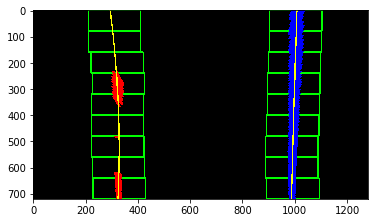

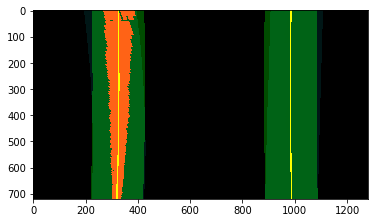

In [12]:
lines = (Line(), Line())

### Visualization
windows_line = sliding_windows( warped_images[1], lines )
plt.imshow( windows_line );


margin_line = line_margin( warped_images[0], lines )
plt.figure()
plt.imshow( margin_line );

#### Draw Lane 

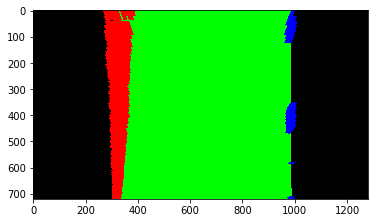

In [13]:
def draw_lane(binary_warped):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    out_img = np.dstack((warp_zero,warp_zero,warp_zero))
    
    # Get points for drawing
    ploty = np.linspace(0, warp_zero.shape[0]-1, warp_zero.shape[0] )
    left_fitx = lines[0].current_fit[0]*ploty**2 + lines[0].current_fit[1]*ploty + lines[0].current_fit[2]
    right_fitx = lines[1].current_fit[0]*ploty**2 + lines[1].current_fit[1]*ploty + lines[1].current_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))
    
    # Color in left and right line pixels
    out_img[lines[0].ally, lines[0].allx] = [255, 0, 0]
    out_img[lines[1].ally, lines[1].allx] = [0, 0, 255]
    
    return out_img

plt.imshow( draw_lane(warped_images[0]) )

#### Measuring Curvature and distance from center

In [50]:
def get_measures(img):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    y_eval = np.max(ploty).astype(int)

    L_line_fit = lines[0].current_fit
    L_line_fitx = L_line_fit[0]*ploty**2 + L_line_fit[1]*ploty + L_line_fit[2]
    R_line_fit = lines[1].current_fit
    R_line_fitx = R_line_fit[0]*ploty**2 + R_line_fit[1]*ploty + R_line_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    L_line_fit_cr = np.polyfit(ploty*ym_per_pix, L_line_fitx*xm_per_pix, 2)
    R_line_fit_cr = np.polyfit(ploty*ym_per_pix, R_line_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    lines[0].radius_of_curvature = ((1+(2*L_line_fit_cr[0]*y_eval*ym_per_pix+L_line_fit_cr[1])**2)**1.5) / np.absolute(2*L_line_fit_cr[0])
    lines[1].radius_of_curvature = ((1+(2*R_line_fit_cr[0]*y_eval*ym_per_pix+R_line_fit_cr[1])**2)**1.5) / np.absolute(2*R_line_fit_cr[0])

    # get distance from center 
    center = img.shape[1]/2
    lane_center = (R_line_fitx[y_eval]-L_line_fitx[y_eval])/2+L_line_fitx[y_eval]
    center_diff = center - lane_center
    #correct pixel coordinates
    center_diff_cr = center_diff*xm_per_pix
    
    lines[0].line_base_pos = center_diff_cr
    lines[1].line_base_pos = center_diff_cr

get_measures(warped_images[0])
print("Curves", lines[0].radius_of_curvature, lines[1].radius_of_curvature )
if lines[0].line_base_pos<0:
    txt = "{0:.2f}m L".format(abs(lines[0].line_base_pos))
elif lines[0].line_base_pos>0:
    txt = "{0:.2f}m R".format(abs(lines[0].line_base_pos))
else:
    txt = "{0:.2f} Center".format(abs(lines[0].line_base_pos))
print("Position", lines[0].line_base_pos, "Formated", txt )


Curves 533.436256441 629.751008337
Position -0.336291444564 Formated 0.34m L


In [55]:
# Sanity Check

pprint( vars(lines[0]) )
print("------------------")
pprint( vars(lines[1]) )

{'allx': array([227, 228, 229, ..., 386, 387, 388]),
 'ally': array([  0,   0,   0, ..., 719, 719, 719]),
 'best_fit': None,
 'bestx': None,
 'current_fit': array([ -3.07886264e-04,   3.90138356e-01,   2.50178972e+02]),
 'detected': True,
 'diffs': array([ 0.,  0.,  0.]),
 'line_base_pos': -0.33629144456411625,
 'radius_of_curvature': 533.43625644132283,
 'recent_fit': [],
 'recent_xfitted': []}
------------------
{'allx': array([ 928,  929,  930, ..., 1044, 1045, 1046]),
 'ally': array([155, 155, 155, ..., 708, 708, 708]),
 'best_fit': None,
 'bestx': None,
 'current_fit': array([ -2.60801823e-04,   4.33354999e-01,   8.58964279e+02]),
 'detected': True,
 'diffs': array([ 0.,  0.,  0.]),
 'line_base_pos': -0.33629144456411625,
 'radius_of_curvature': 629.75100833721547,
 'recent_fit': [],
 'recent_xfitted': []}


## Video Pipeline

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

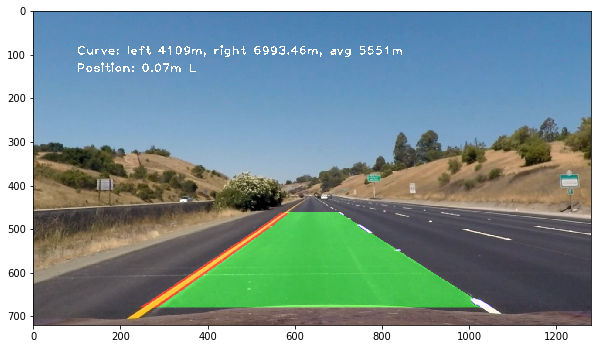

In [46]:
def process_image(image):
    # Undistort image
    image = undistort(image, objpoints, imgpoints)
    
    # Get color and Gradient threshold 
    binary = threshold(image)
    
    # Apply perspective transform 
    warped = warp(binary)
    
    # Detect Lines
    detected_lines = detect_lines(warped, lines)
    
    # Meassure curvature and position from center
    get_measures(warped)
    
    # Draw lane lines
    drawn_lane = draw_lane(warped)
    # Warp lane lines back to original image
    unwarped = warp(drawn_lane, True)
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, unwarped, 0.5, 0)
    
    
    # Print Curvature on image
    avg_curve = (lines[0].radius_of_curvature+lines[1].radius_of_curvature)/2
    txt = "Curve: left {0:.0f}m, right {1:.2f}m, avg {2:.0f}m".format(lines[0].radius_of_curvature,
                                                                      lines[1].radius_of_curvature,
                                                                      avg_curve)
    cv2.putText(result, txt, (100,100), cv2.FONT_HERSHEY_PLAIN, 1.9, (255,255,255), 2)
    # Print position
    if lines[0].line_base_pos<0:
        txt2 = "Position: {0:.2f}m L".format(abs(lines[0].line_base_pos))
    elif lines[0].line_base_pos>0:
        txt2 = "Position: {0:.2f}m R".format(abs(lines[0].line_base_pos))
    else:
        txt2 = "Position: {0:.2f} Center".format(abs(lines[0].line_base_pos))
    cv2.putText(result, txt2, (100,140), cv2.FONT_HERSHEY_PLAIN, 1.9, (255,255,255), 2)
    
    return result

### Visualization
lines = (Line(), Line())
plt.figure(figsize=(10,10))
plt.imshow( process_image(images[0]) );

#plt.figure(figsize=(10,10))
#plt.imshow( process_image(cal_undistort(cv2.cvtColor( cv2.imread("test_images2/img1.png"), cv2.COLOR_BGR2RGB), objpoints, imgpoints)) );

### Clip 1

In [48]:
clip1 = "project_video.mp4"
clip1_output = 'output_videos/project_annotated.mp4'

# reset lines
lines = (Line(), Line())

video = VideoFileClip(clip1).subclip(0,5) #.subclip(38,42) .subclip(20,25) 
video_clip = video.fl_image(process_image)
%time video_clip.write_videofile(clip1_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_annotated.mp4
[MoviePy] Writing video output_videos/project_annotated.mp4


 99%|█████████▉| 125/126 [00:38<00:00,  3.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_annotated.mp4 

CPU times: user 46.8 s, sys: 3.84 s, total: 50.6 s
Wall time: 40.1 s


In [49]:
video = io.open(clip1_output, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

In [ ]:
clip2 = "challenge_video.mp4"
clip2_output = 'output_videos/challenge_annotated.mp4'

# reset lines
lines = (Line(), Line())

video = VideoFileClip(clip2).subclip(0,1)
video_clip = video.fl_image(process_image)
%time video_clip.write_videofile(clip2_output, audio=False)

In [ ]:
video = io.open(clip2_output, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))

In [ ]:
clip3 = "harder_challenge_video.mp4"
clip3_output = 'output_videos/harder_challenge_annotated.mp4'

# reset lines
lines = (Line(), Line())

video = VideoFileClip(clip3).subclip(0,1)
video_clip = video.fl_image(process_image)
%time video_clip.write_videofile(clip3_output, audio=False)

In [ ]:
video = io.open(clip3_output, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
<video width="640" height="360" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
</video>'''.format(encoded.decode('ascii')))